In [1]:
%pip install ipykernel numpy pandas matplotlib seaborn scikit-learn xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Підготовчий етап
**Датасет:** California Housing Prices [https://www.kaggle.com/datasets/camnugent/california-housing-prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices)

1. Провести аналіз вибраного набору даних,
1. визначити вхідні та вихідні параметри,
1. візуалізувати залежності входів та виходу,
1. детектувати аномалії, неповні зразки у даних, тощо,
1. провести кореляційний аналіз входів та виходів набору даних, виявити взаємозалежні фактори.
1. Провести підготовку даних до подальшого використання.
1. Обраний та відфільтрований набір даних розбити на навчальну та тестову частину (70% на навчання, 30% на тест).

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# import sklearn as skl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
# from sklearn.preprocessing import OneHotEncoder

import time
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
# from sklearn.model_selection import GridSearchCV

In [3]:
data_start = pd.read_csv("Data/housing.csv")
print(data_start.shape)
data_start.head()

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


ocean_proximity виглядає важливою, по ідеї чим ближче до моря, тим дорожче, тому перетворимо її, на більш зрозумілу річ для регресії

In [4]:
# texts = data_start.ocean_proximity.unique()
# hot_encoder, hot_decoder = {item: i for i, item in enumerate(texts)}, {i: item for i, item in enumerate(texts)}
# def hot_coder(x, hot_dict: dict):
#     return hot_dict[x]
# # data_start.ocean_proximity = data_start.ocean_proximity.apply(hot_coder, args=(hot_encoder, ))

In [5]:
data = pd.get_dummies(data_start, columns=['ocean_proximity'], drop_first=False)
data = data.rename(columns={
    "ocean_proximity_<1H OCEAN": "1h_ocean",
    "ocean_proximity_INLAND": "inland",
    "ocean_proximity_ISLAND": "island",
    "ocean_proximity_NEAR BAY": "near_bay",
    "ocean_proximity_NEAR OCEAN": "near_ocean",
})
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,1h_ocean,inland,island,near_bay,near_ocean
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,False,False,True,False


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


Кількість total_bedrooms менше ніж в інших, є НаН

Дуже дивне значення коштування дому 500001.00, виглядає як спеціально обрізані числа, тому краще дропнути їх

In [7]:
print(f"Кількість записів з обмеженням ціни: {data[data.median_house_value == 500001].shape[0]}")

Кількість записів з обмеженням ціни: 965


In [8]:
data = data[data.median_house_value < 500001]

In [9]:
data.total_bedrooms.value_counts(dropna=False)

total_bedrooms
NaN       200
280.0      52
393.0      48
348.0      47
331.0      47
         ... 
1765.0      1
2453.0      1
1103.0      1
1087.0      1
1871.0      1
Name: count, Length: 1906, dtype: int64

In [10]:
data[data.total_bedrooms.isna()]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,1h_ocean,inland,island,near_bay,near_ocean
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,False,False,False,True,False
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,False,False,False,True,False
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,False,False,False,True,False
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,False,False,False,True,False
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,False,False,False,False,True
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,False,False,False,False,True
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,True,False,False,False,False
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,True,False,False,False,False


Дамо total_bedrooms її медіанні значення

In [11]:
data['total_bedrooms'] = data['total_bedrooms'].fillna(data['total_bedrooms'].median())
data[data.total_bedrooms.isna()].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,1h_ocean,inland,island,near_bay,near_ocean


In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,19675.0,-119.563192,2.006108,-124.3500,-121.7600,-118.50,-117.9900,-114.3100
latitude,19675.0,35.651780,2.149802,32.5400,33.9300,34.27,37.7300,41.9500
housing_median_age,19675.0,28.386277,12.509113,1.0000,18.0000,28.00,37.0000,52.0000
total_rooms,19675.0,2619.763659,2181.348207,2.0000,1438.0000,2111.00,3120.0000,39320.0000
total_bedrooms,19675.0,538.592173,420.389237,2.0000,299.0000,436.00,645.0000,6445.0000
population,19675.0,1440.812198,1143.648725,3.0000,796.0000,1179.00,1746.0000,35682.0000
households,19675.0,501.186023,383.264636,2.0000,282.0000,411.00,606.0000,6082.0000
median_income,19675.0,3.676717,1.570272,0.4999,2.5268,3.45,4.5826,15.0001
median_house_value,19675.0,192477.921017,97711.509613,14999.0000,116600.0000,173800.00,248200.0000,500000.0000


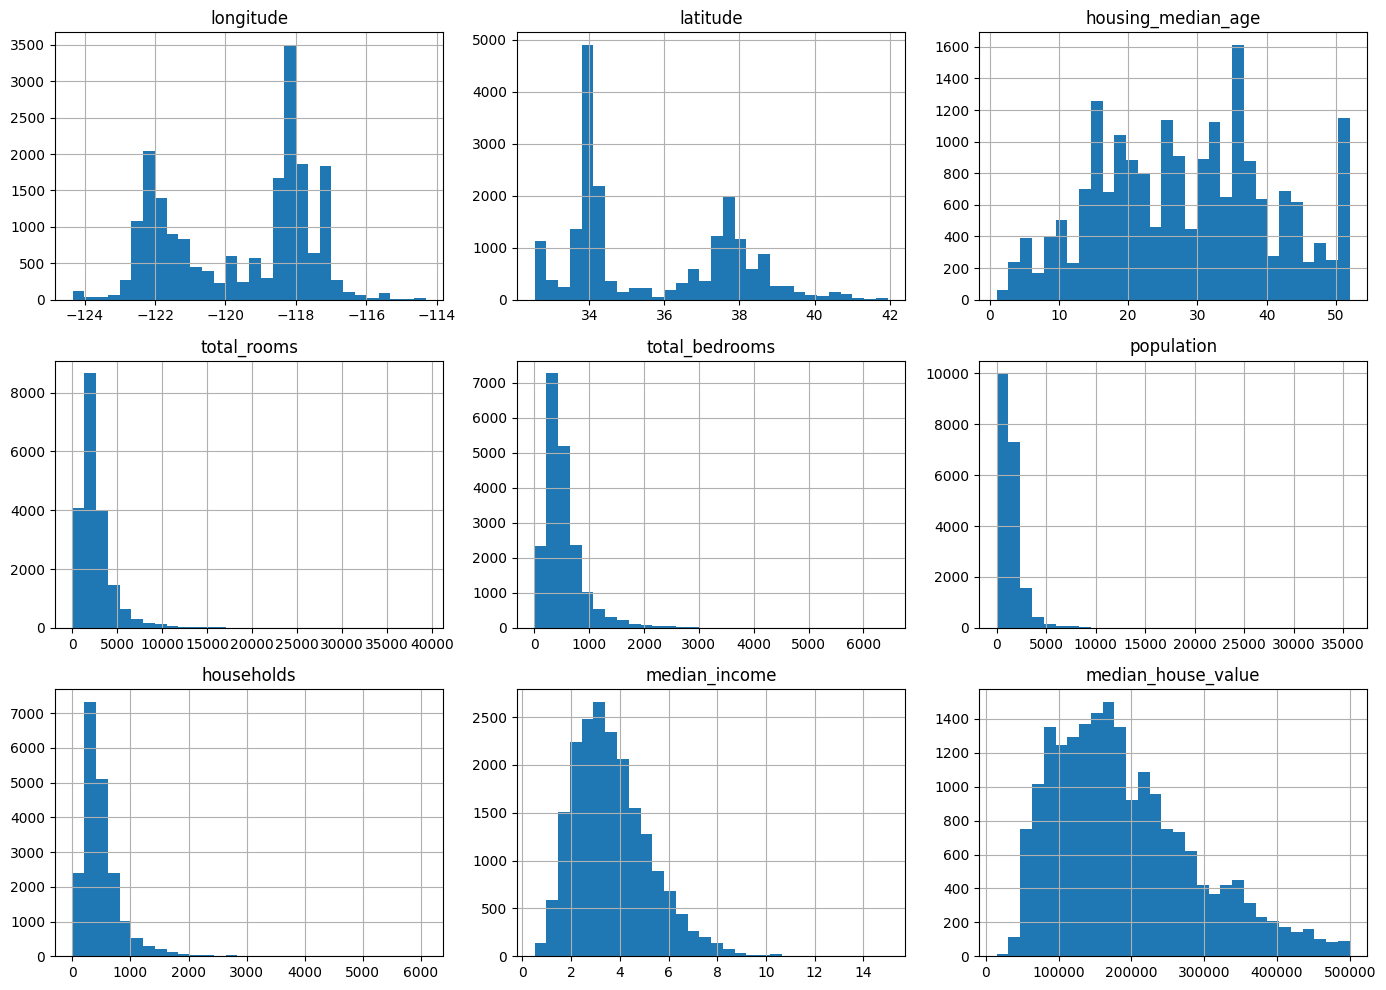

In [13]:
data.hist(bins=30, figsize=(14,10))
plt.tight_layout()
plt.show()


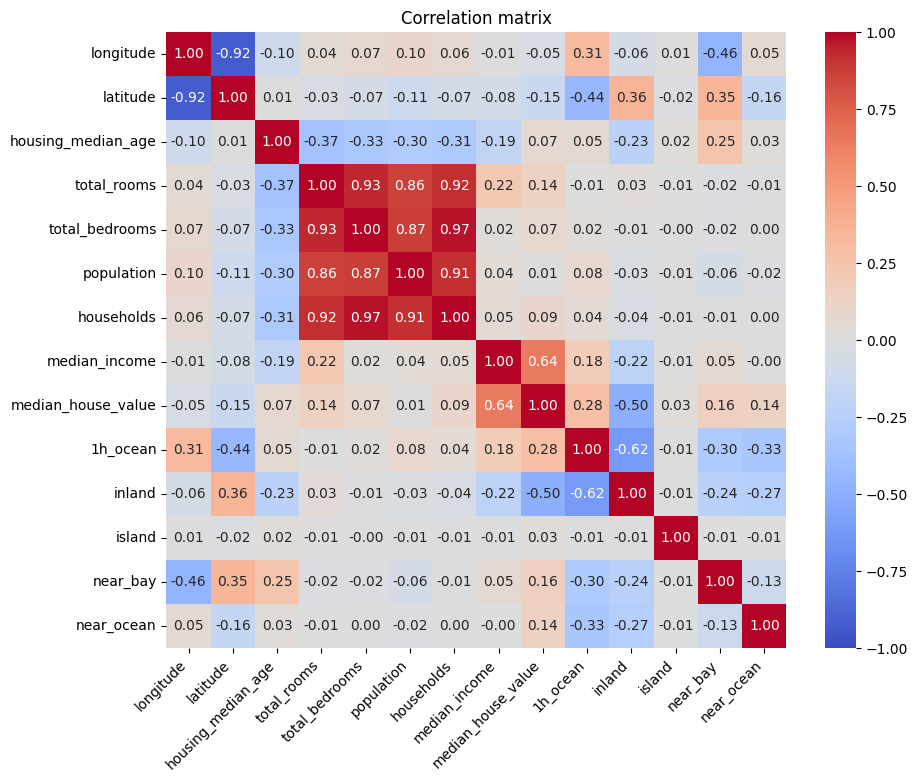

In [14]:
corr = data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation matrix')
plt.show()


Вхідними параметрами будуть: housing_median_age, average_rooms_per_household (total_rooms/households), average_bedrooms_per_room (total_bedrooms/households / average_rooms_per_household), average_population_per_household (population/households), households, median_income, 1h_ocean, inland, island, near_bay, near_ocean

Вихідним параметром буде: median_house_value

In [ ]:
data['average_rooms_per_household'] = data['total_rooms'] / data['households']
data['average_bedrooms_per_room'] = (data['total_bedrooms'] / data['households']) / (data['average_rooms_per_household'])   # + 1e-6
data['average_population_per_household'] = data['population'] / data['households']

data[['average_rooms_per_household','average_bedrooms_per_room','average_population_per_household']].head()

,average_rooms_per_household,average_bedrooms_per_room,average_population_per_household,log_median_house_value
0,6.984127,0.146591,2.555556,13.022766
1,6.238137,0.155797,2.109842,12.789687
2,8.288136,0.129516,2.802260,12.771673
3,5.817352,0.184458,2.547945,12.740520
4,6.281853,0.172096,2.181467,12.743154


In [ ]:
features = data.columns.drop(['total_rooms', 'total_bedrooms', 'population', 'median_house_value'])  # 'latitude', 'longitude', 
X = data[features].copy()
y = data['median_house_value'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# X_train_scaled = X_train.astype(float)
# X_test_scaled = X_test.astype(float)
X_train_scaled.shape, X_test_scaled.shape

((13772, 13), (5903, 13))

# Реалізація моделі

1. SciKit learn
1. XGBoost
1. Vanilla Python (Numpy/Pandas)

## SciKit learn

In [17]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"[Scikit-Learn Linear Regression] RMSE: {rmse_lr:.2f}")
print(f"[Scikit-Learn Linear Regression] R2: {r2_lr:.4f}")

[Scikit-Learn Linear Regression] RMSE: 64001.82
[Scikit-Learn Linear Regression] R2: 0.5833


In [18]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"[Ridge Regression] RMSE: {rmse_ridge:.2f}")
print(f"[Ridge Regression] R2: {r2_ridge:.4f}")

lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"[Ridge Regression] RMSE: {rmse_lasso:.2f}")
print(f"[Ridge Regression] R2: {r2_lasso:.4f}")

[Ridge Regression] RMSE: 64001.92
[Ridge Regression] R2: 0.5833
[Ridge Regression] RMSE: 64001.79
[Ridge Regression] R2: 0.5833


## XGBoost

In [19]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"[XGBoost] RMSE: {rmse_xgb:.2f}")
print(f"[XGBoost] R2: {r2_xgb:.4f}")

[XGBoost] RMSE: 42935.20
[XGBoost] R2: 0.8125


## Vanilla Python (Numpy/Pandas)

In [20]:
class CustomLinearRegressionGD:
    def __init__(self, learning_rate: float = 0.01, iterations: int = 1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        count_samples, count_features = X.shape
        self.weights = np.zeros(count_features)
        self.bias = 0

        for _ in range(self.iterations):
            y_predicted = (X @ self.weights) + self.bias

            dw = (1 / count_samples) * (X.T @ (y_predicted - y))
            db = (1 / count_samples) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return (X @ self.weights) + self.bias

In [21]:
X_train_vanilla = np.concat((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled.values), axis=1, dtype=float)
X_test_vanilla = np.concat((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled.values), axis=1, dtype=float)
y_train_vanilla = y_train.values

XT_X = X_train_vanilla.T @ X_train_vanilla

XT_X_inv = np.linalg.inv(XT_X)

XT_y = X_train_vanilla.T  @ y_train_vanilla

theta = XT_X_inv @ XT_y

y_pred_vanilla = X_test_vanilla @ theta

mse_vanilla = np.mean((y_test - y_pred_vanilla) ** 2)
rmse_vanilla = np.sqrt(mse_vanilla)
ss_res = np.sum((y_test - y_pred_vanilla) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2_vanilla = 1 - (ss_res / ss_tot)

print(f"[Vanilla Python (Analytic)] RMSE: {rmse_vanilla:.2f}")
print(f"[Vanilla Python (Analytic)] R2: {r2_vanilla:.4f}")

custom_rg = CustomLinearRegressionGD(learning_rate=0.1, iterations=2000)
custom_rg.fit(X_train_scaled, y_train)

y_pred_custom = custom_rg.predict(X_test_scaled)

rmse_custom = np.sqrt(mean_squared_error(y_test, y_pred_custom))
r2_custom = r2_score(y_test, y_pred_custom)

print(f"[Vanilla Python (MyClass)] RMSE: {rmse_custom:.2f}")
print(f"[Vanilla Python (MyClass)] R2: {r2_custom:.4f}")

[Vanilla Python (Analytic)] RMSE: 64599.41
[Vanilla Python (Analytic)] R2: 0.5755
[Vanilla Python (MyClass)] RMSE: 64002.80
[Vanilla Python (MyClass)] R2: 0.5833


# Аналіз результатів

1. Вибір оптимальних параметрів регресій, їх обгрунтування
2. Оцінка помилок на начальній та тестовій вибірках
3. Порівняння результатів різних підходів (співпали чи ні, причини чому могли не співпасти, runtime тощо)
4. Порівняти результати з аналогічними результатами, які отримані в результаті використання вбудованих функцій
5. Результати оформити протоколом

In [22]:
final_results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso', 'XGBoost', 'Vanilla Python (Analytic)', 'Vanilla Python (MyClass)'],
    'RMSE': [rmse_lr, rmse_ridge, rmse_lasso, rmse_xgb, rmse_vanilla, rmse_custom],
    'R2 Score': [r2_lr, r2_ridge, r2_lasso, r2_xgb, r2_vanilla, r2_custom]
})

final_results.sort_values(by='R2 Score', ascending=False)

,Model,RMSE,R2 Score
3,XGBoost,42935.202216,0.812488
2,Lasso,64001.794433,0.583336
0,Linear Regression,64001.817833,0.583335
1,Ridge,64001.915235,0.583334
5,Vanilla Python (MyClass),64002.795526,0.583323
4,Vanilla Python (Analytic),64599.412259,0.575518


XGBoost показав найкращий результат (R2 = 0.81 (83 якщо не прибирати обмежені зверху значення))

Усі лінійні моделі показали схожі результати (R2 = 0.58 (59 якщо не прибирати обмежені зверху значення)).

Ridge та Lasso показали результат такий же як й інші.

Власна реалізація досягла таких же результатів.

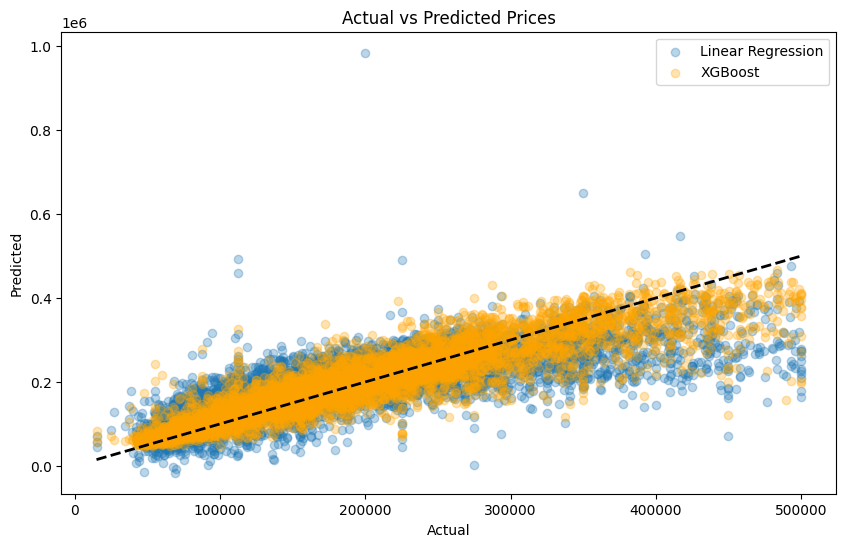

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.3, label='Linear Regression')
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='orange', label='XGBoost')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()

# Контрольні питання

1. **Що таке ансамблювання та для чого воно використовується?**
Ансамблювання — поєднання кількох моделей для отримання кращої узагальнюючої здатності. Зазвичай знижує дисперсію, зміщення або отримує кращу стабільність.

2. **Які моделі базуються на принципі лінійної регресії?**
Ridge, Lasso тощо.

3. **Що таке XGBoost?**
XGBoost — ефективна імплементація градієнтного бустингу дерев рішень з оптимізаціями по швидкості та пам'яті, регуляризацією, обробкою відсутніх значень і ранньою зупинкою.
